In [1]:
import os

import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
tf.keras.backend.set_floatx('float64')
from tensorflow.keras import Model
from flow_layers import parametric_real_nvp # For vector parameteric maps

# Plotting
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
#Build the model which does basic map of inputs to coefficients
class normalizing_flow(Model):
    def __init__(self,data,params):
        super(normalizing_flow, self).__init__()

        self.dim = data.shape[1]
        self.data = data
        self.params = params

        # Define real_nvp flow layers
        self.l0 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l1 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l2 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l3 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        

        # Training optimizer
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)

        # Moving statistics
        self.moving_mean = None
        self.moving_std = None

    @tf.function
    def call(self, x, params): # x to z (forward)

        h1, ldj1 = self.l0(x,params) # Individual layer calls
        h2, ldj2 = self.l1(h1,params)
        h3, ldj3 = self.l2(h2,params)
        hfinal, ldj4 = self.l3(h3,params)

        logdet = ldj1+ldj2+ldj3+ldj4

        log_prior = -0.5*tf.math.reduce_sum(tf.math.square(hfinal))

        neg_ll = - log_prior - logdet

        return hfinal, neg_ll

    @tf.function
    def call_backward(self,z,params): # z to x

        h = self.l3.invert(z,params) # Individual layer calls
        h = self.l2.invert(h,params) # Individual layer calls
        h = self.l1.invert(h,params) # Individual layer calls
        h = self.l0.invert(h,params) # Individual layer calls

        return h

    # perform gradient descent
    @tf.function
    def network_learn(self,x,params):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            _, neg_ll = self.call(x,params)
            g = tape.gradient(neg_ll, self.trainable_variables)

        self.train_op.apply_gradients(zip(g, self.trainable_variables))

    @tf.function
    def extract_gradient(self,input_grad,params):
        params = tf.convert_to_tensor(params)
        z = tf.convert_to_tensor(input_grad)
        
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(z)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(params)
                with tf.GradientTape(persistent=True) as tape3:
                    tape3.watch(params)
                    x = self.call_backward(z,params)
    
                g1 = tape3.batch_jacobian(x, params)
            g2 = tape2.batch_jacobian(g1, params)
        v = tape1.batch_jacobian(g1, z)
        
        return g1, g2, v

    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 10
        best_valid_loss = np.inf # Some large number 

        self.num_batches = 10
        self.ntrain = int(0.7*self.data.shape[0])
        self.nvalid = self.data.shape[0] - int(0.7*self.data.shape[0])

        self.train_data = self.data[:self.ntrain]
        self.train_params = self.params[:self.ntrain]

        self.valid_data = self.data[self.ntrain:]
        self.valid_params = self.params[self.ntrain:]

        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int(self.ntrain/self.num_batches)
        
        for i in range(2000):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                batch_data = self.train_data[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                batch_params = self.train_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(batch_data,batch_params)

            # Validation loss
            valid_loss = 0.0

            for batch in range(self.num_batches):
                batch_data = self.valid_data[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                batch_params = self.valid_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                valid_loss = valid_loss + np.sum(self.call(batch_data,batch_params)[1].numpy())

            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation negative log likelihood from:',best_valid_loss,' to:', valid_loss)
                
                best_valid_loss = valid_loss

                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation negative log likelihood (no improvement):',valid_loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                self.train_op._hyper['learning_rate'] = 0.5*self.train_op._hyper['learning_rate']
                print('Reduced learning rate to',self.train_op._hyper['learning_rate'])
                stop_iter = 0
                
                if self.train_op._hyper['learning_rate'] < 1e-6:
                    break

In [3]:
def visualize_samples(samples,params,time=0,eps=0.01):
    # At a specific time
    plot_samples = []
    for i in range(params.shape[0]):
        if params[i,0] < time+eps and params[i,0] > time-eps:
            plot_samples.append(samples[i])

    plot_samples = np.asarray(plot_samples)

    plt.figure()
    plt.scatter(plot_samples[:,0],plot_samples[:,1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Density at parameter:'+str(time))
    plt.show()

In [4]:
train_mode = False
num_samples = 1000
noise_list = np.arange(0.0,1.0,step=0.01)

train_list = []
param_list = []
for i in range(len(noise_list)):
    train_list.append(make_moons(n_samples=num_samples,noise=noise_list[i])[0])
    param_list.append(np.ones(shape=(num_samples,1))*noise_list[i])

train_data = train_list[0]
param_data = param_list[0]
for i in range(1,len(train_list)):
    train_data = np.concatenate((train_data,train_list[i]),axis=0)
    param_data = np.concatenate((param_data,param_list[i]),axis=0)

In [5]:
idx = np.arange(start=0,stop=train_data.shape[0])
np.random.shuffle(idx)

train_data = train_data[idx,:]
param_data = param_data[idx,:]

In [6]:
# Normalizing flow training
flow_model = normalizing_flow(train_data,param_data)
z = np.random.normal(size=train_data.shape)
pre_samples = flow_model.call_backward(z,param_data) # Forward is x to z, Backward is z to x
pre_samples = pre_samples.numpy()

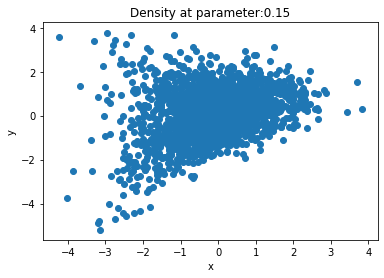

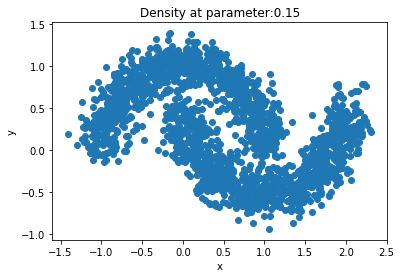

In [7]:
visualize_samples(pre_samples,param_data,time=0.15)
visualize_samples(train_data,param_data,time=0.15)

In [8]:
if train_mode:
    flow_model.train_model()
    flow_model.load_weights('./checkpoints/my_checkpoint')
else:
    flow_model.load_weights('./checkpoints/my_checkpoint')

In [9]:
z = np.random.normal(size=train_data.shape)
post_samples = flow_model.call_backward(z,param_data)
post_samples = post_samples.numpy()

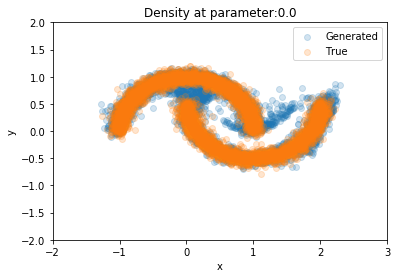

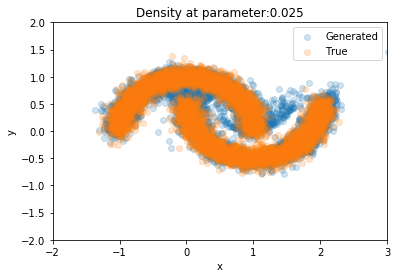

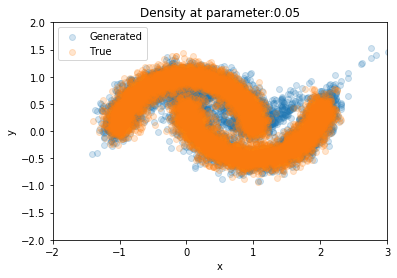

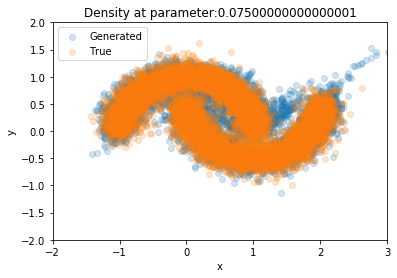

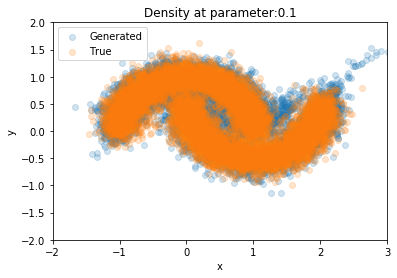

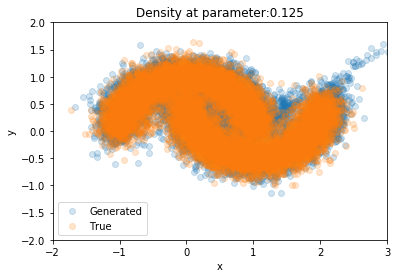

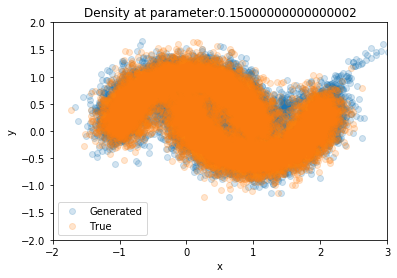

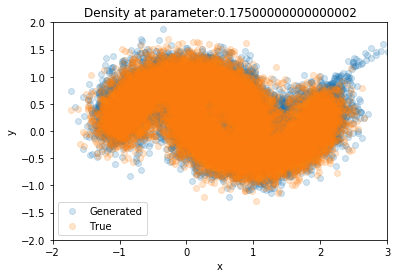

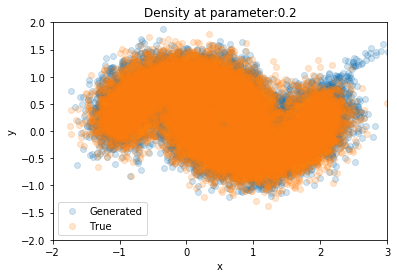

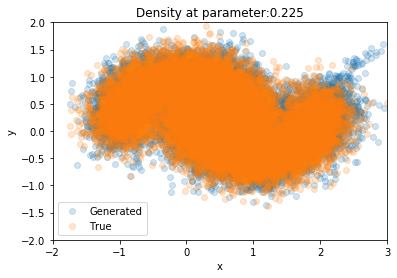

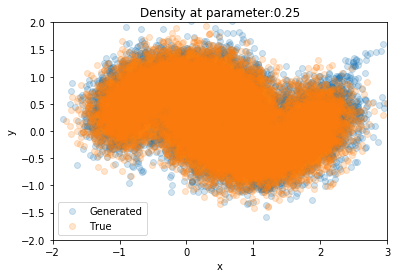

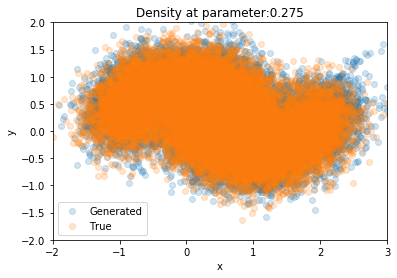

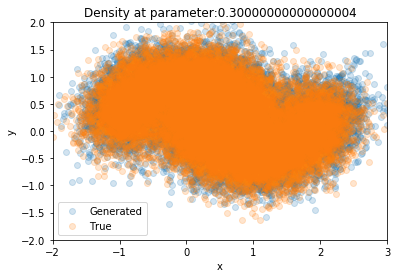

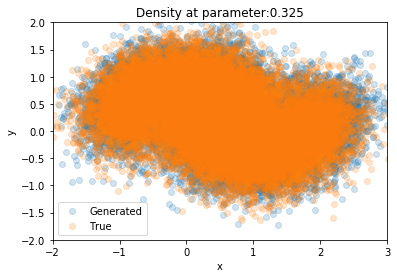

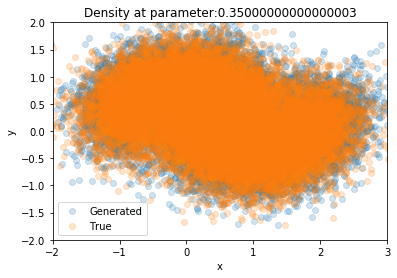

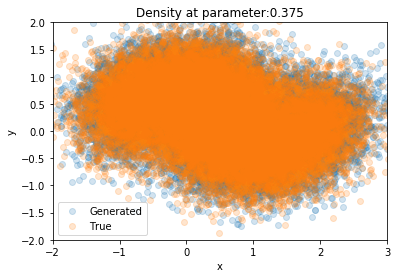

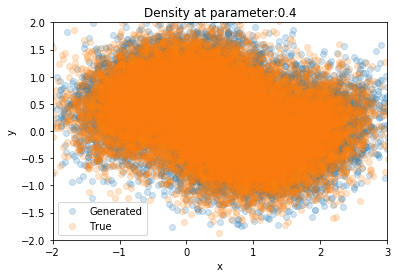

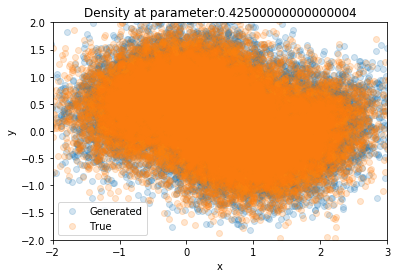

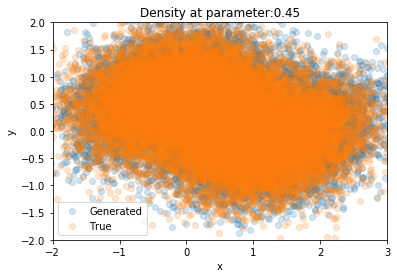

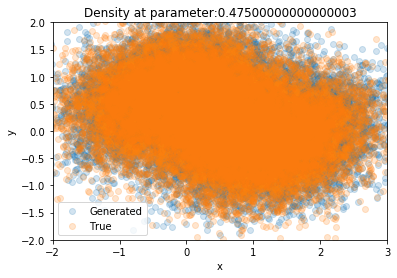

In [10]:
final_time = 0.5
# At a specific parameter
for time in np.arange(0.0,final_time,0.025):
    
    eps = 0.1
    plot_samples = []
    target_samples = []

    for i in range(param_data.shape[0]):
        if param_data[i,0] < time+eps and param_data[i,0] > time-eps:
            plot_samples.append(post_samples[i])
            target_samples.append(train_data[i])

    plot_samples = np.asarray(plot_samples)
    target_samples = np.asarray(target_samples)

    plt.figure()
    plt.scatter(plot_samples[:,0],plot_samples[:,1],label='Generated',alpha=0.2)
    plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2,label='True')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((-2,3))
    plt.ylim((-2,2))
    plt.title('Density at parameter:'+str(time))
    plt.legend()
    plt.show()

In [12]:
zx = np.linspace(-1, 1, 200)
zy = np.linspace(-1, 1, 200)

zxv, zyv = np.meshgrid(zx, zy)
zxvflat = zxv.reshape(-1,1)
zyvflat = zyv.reshape(-1,1)

grid = np.concatenate((zxvflat,zyvflat),axis=-1)
params = np.zeros(shape=(grid.shape[0],1))

### Extracting the gradients etc and plotting

/home/rmlans/miniconda3/envs/tf2_env/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Reshape:0", shape=(None, 40000), dtype=float64), dense_shape=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


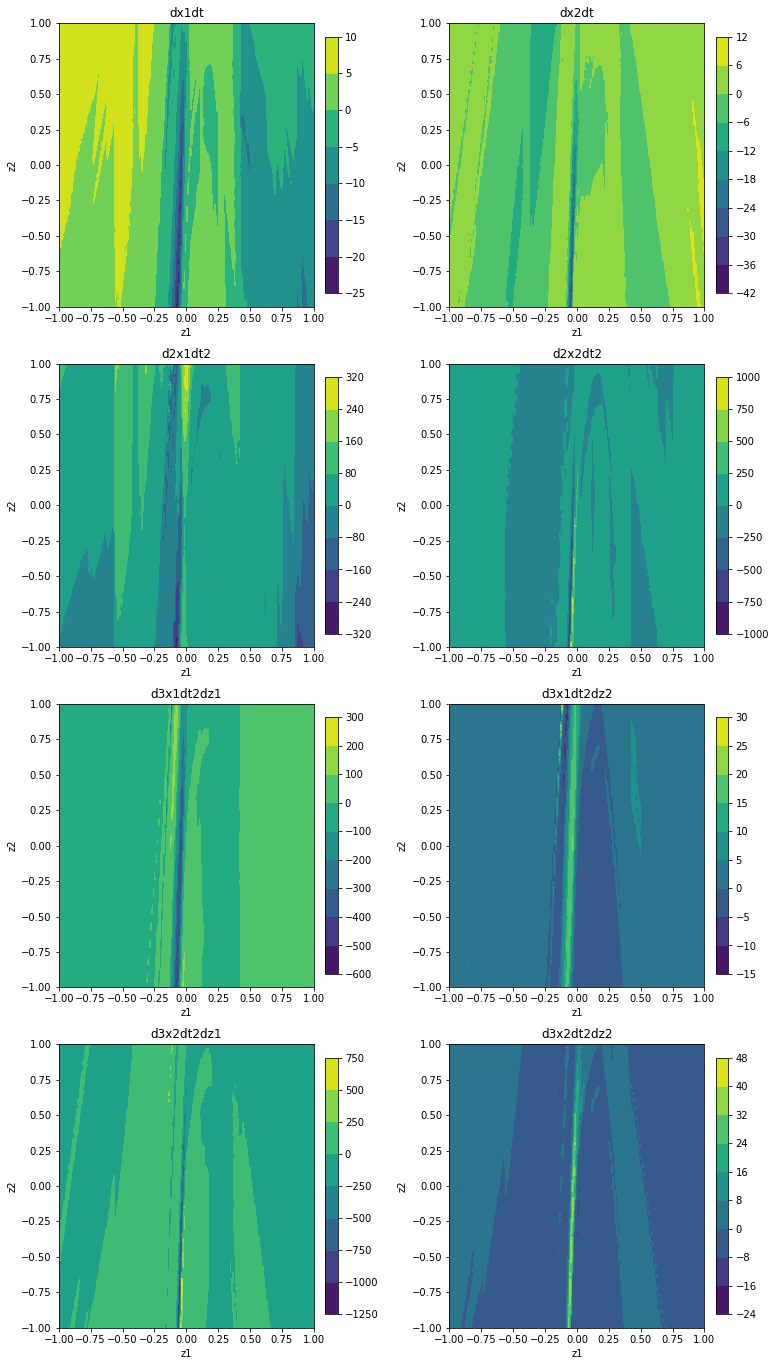

In [22]:
params[:,0] = 0.0 # Time
g1, g2, v = flow_model.extract_gradient(grid,params)

# Gradient of x1, x2 with respect to t (velocity)
dx1dt = g1.numpy()[:,0,0].reshape(zx.shape[0],zy.shape[0])
dx2dt = g1.numpy()[:,1,0].reshape(zx.shape[0],zy.shape[0])

# Second derivative of x1, x2 with respect to t (acceleration)
d2x1dt2 = g2.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
d2x2dt2 = g2.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])

# Derivative of velocity with respect to z1, z2 (directional derivative of velocity)
d3x1dt2dz1 = v.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
d3x1dt2dz2 = v.numpy()[:,0,0,1].reshape(zx.shape[0],zy.shape[0])
d3x2dt2dz1 = v.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])
d3x2dt2dz2 = v.numpy()[:,1,0,1].reshape(zx.shape[0],zy.shape[0])

fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(12,24))


cs1 = ax[0,0].contourf(zxv,zyv,dx1dt)#,levels=levels)
ax[0,0].set_title('dx1dt')
cs2 = ax[0,1].contourf(zxv,zyv,dx2dt)#,levels=levels)
ax[0,1].set_title('dx2dt')
cs3 = ax[1,0].contourf(zxv,zyv,d2x1dt2)#,levels=levels)
ax[1,0].set_title('d2x1dt2')
cs4 = ax[1,1].contourf(zxv,zyv,d2x2dt2)#,levels=levels)
ax[1,1].set_title('d2x2dt2')

cs5 = ax[2,0].contourf(zxv,zyv,d3x1dt2dz1)#,levels=levels)
ax[2,0].set_title('d3x1dt2dz1')

cs6 = ax[2,1].contourf(zxv,zyv,d3x1dt2dz2)#,levels=levels)
ax[2,1].set_title('d3x1dt2dz2')

cs7 = ax[3,0].contourf(zxv,zyv,d3x2dt2dz1)#,levels=levels)
ax[3,0].set_title('d3x2dt2dz1')

cs8 = ax[3,1].contourf(zxv,zyv,d3x2dt2dz2)#,levels=levels)
ax[3,1].set_title('d3x2dt2dz2')


for i in range(4):
    for j in range(2):
        ax[i,j].set_xlabel('z1')
        ax[i,j].set_ylabel('z2')

fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[1,1],fraction=0.046, pad=0.04)
fig.colorbar(cs5,ax=ax[2,0],fraction=0.046, pad=0.04)
fig.colorbar(cs6,ax=ax[2,1],fraction=0.046, pad=0.04)
fig.colorbar(cs7,ax=ax[3,0],fraction=0.046, pad=0.04)
fig.colorbar(cs8,ax=ax[3,1],fraction=0.046, pad=0.04)
plt.subplots_adjust(wspace = 0.4)
plt.show()

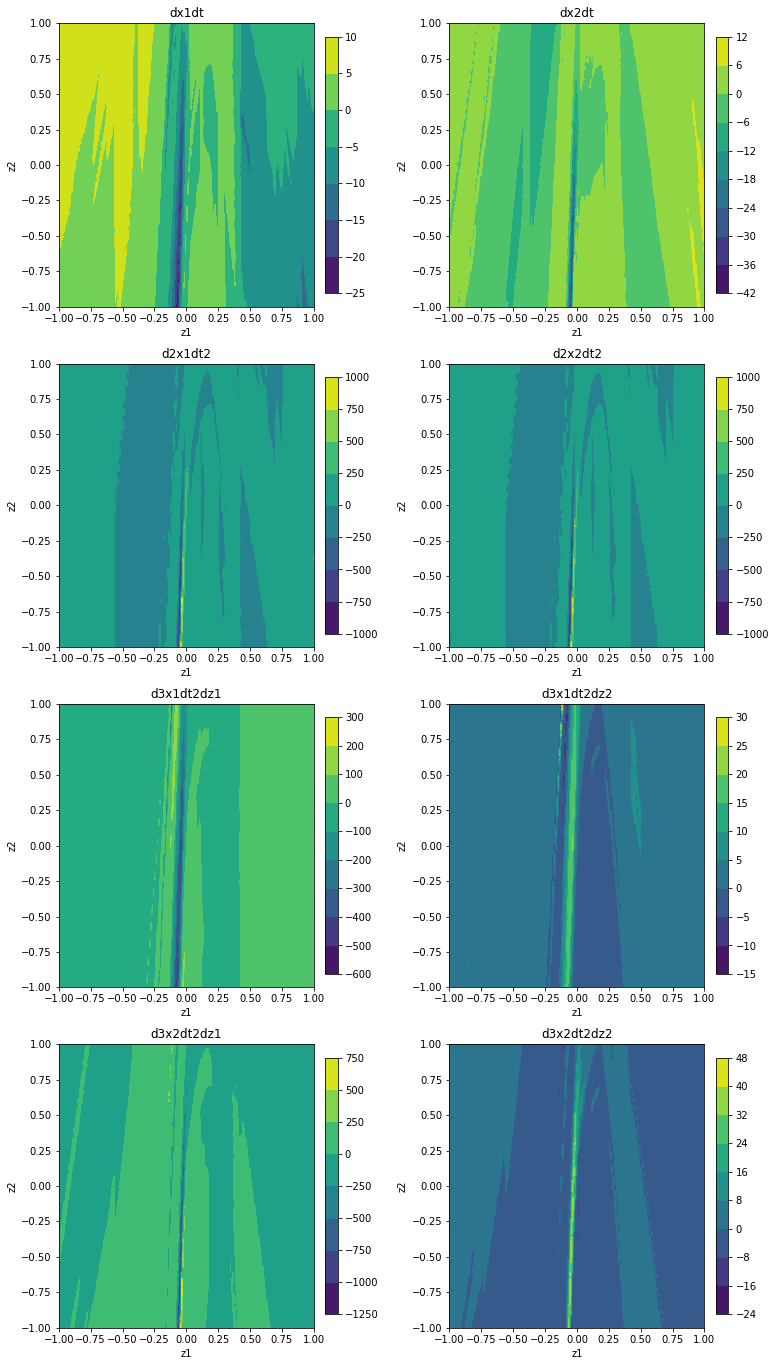

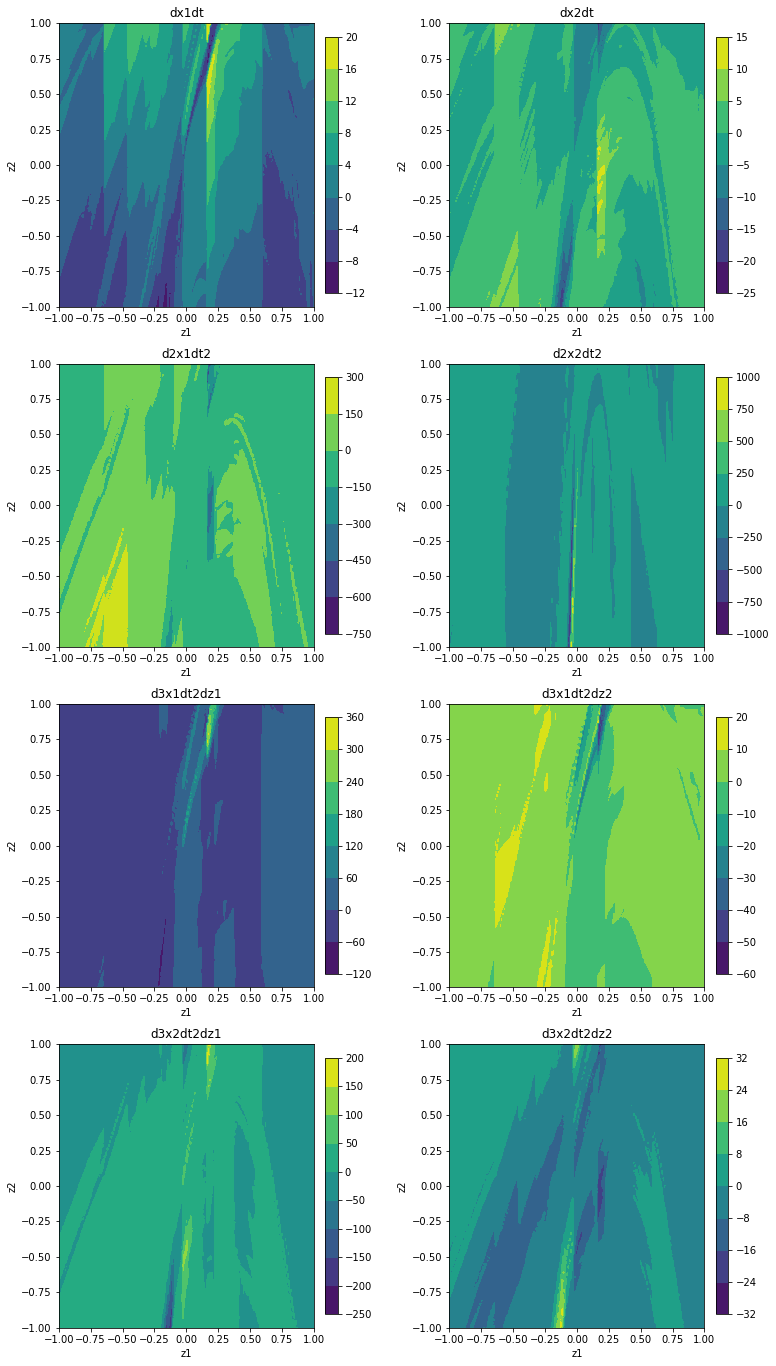

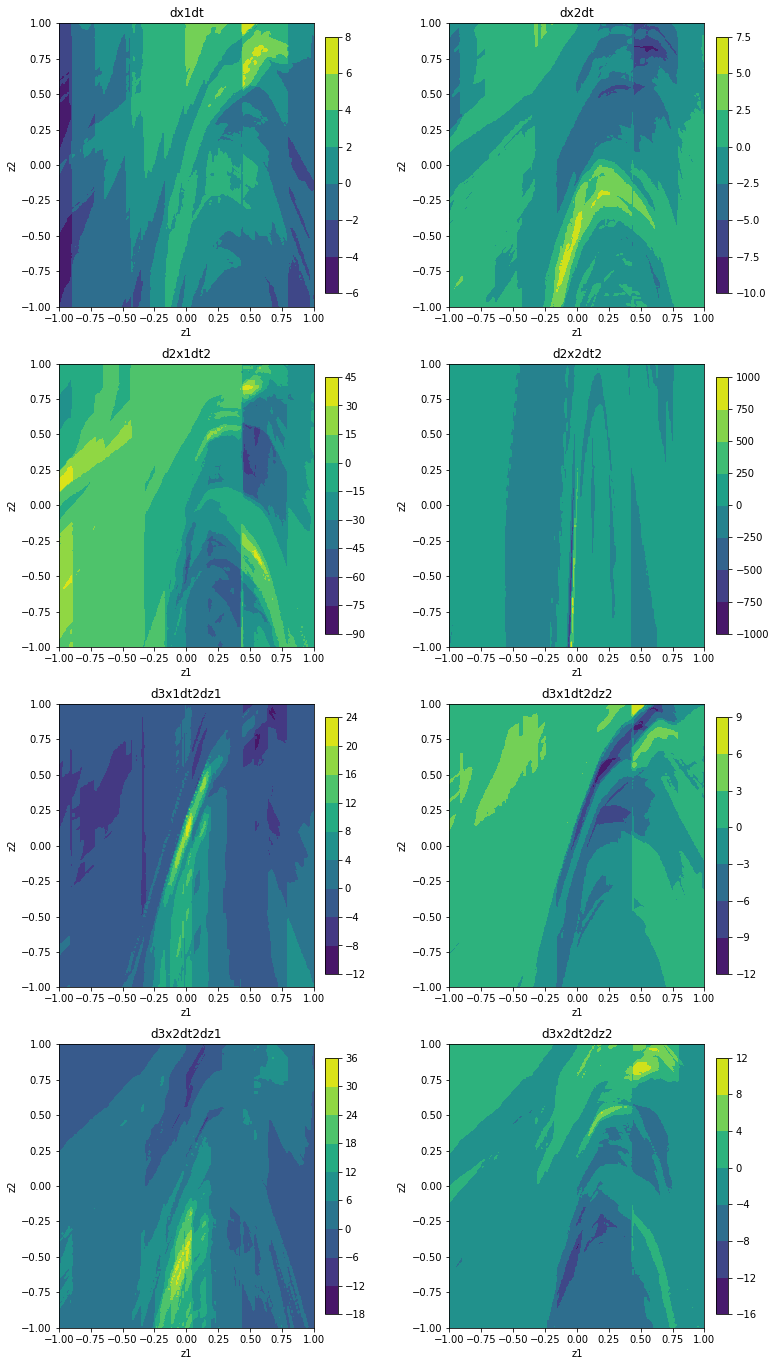

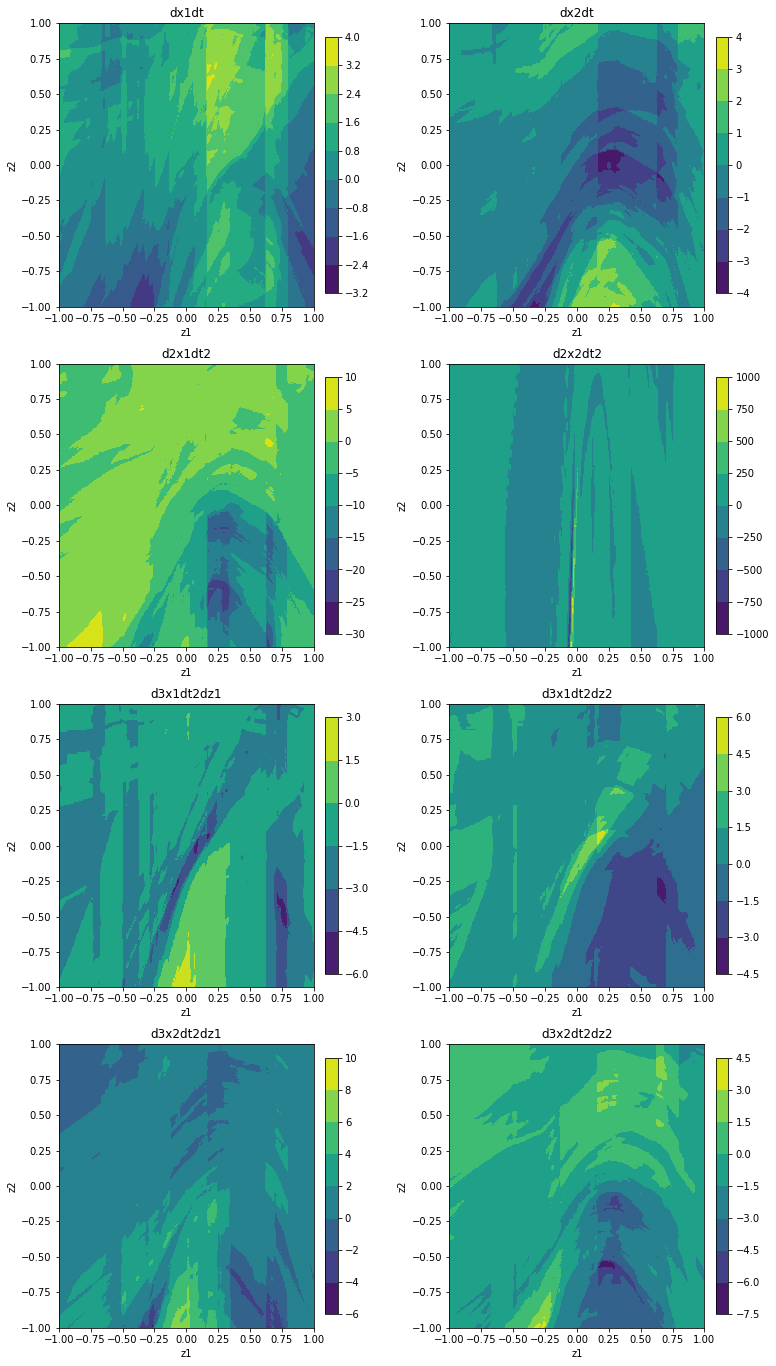

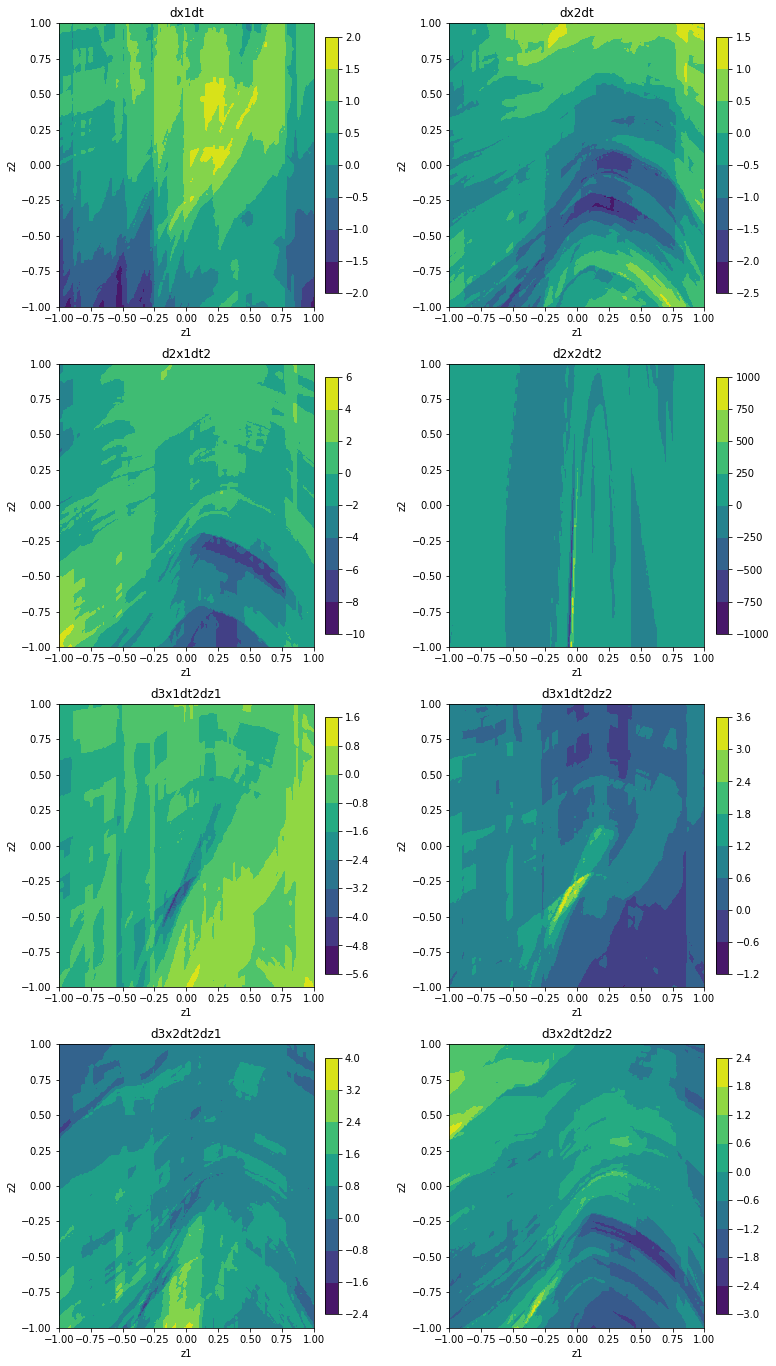

In [24]:
system_data = []
for time in np.arange(0.0,final_time,0.1):
    params[:,0] = time
    g1, g2, v = flow_model.extract_gradient(grid,params)
    
    dx1dt = g1.numpy()[:,0,0].reshape(zx.shape[0],zy.shape[0])
    dx2dt = g1.numpy()[:,1,0].reshape(zx.shape[0],zy.shape[0])
    d2x1dt2 = g2.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
    d2x1dt2 = g2.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])

    d3x1dt2dz1 = v.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
    d3x1dt2dz2 = v.numpy()[:,0,0,1].reshape(zx.shape[0],zy.shape[0])
    d3x2dt2dz1 = v.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])
    d3x2dt2dz2 = v.numpy()[:,1,0,1].reshape(zx.shape[0],zy.shape[0])

    fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(12,24))


    cs1 = ax[0,0].contourf(zxv,zyv,dx1dt)#,levels=levels)
    ax[0,0].set_title('dx1dt')
    cs2 = ax[0,1].contourf(zxv,zyv,dx2dt)#,levels=levels)
    ax[0,1].set_title('dx2dt')
    cs3 = ax[1,0].contourf(zxv,zyv,d2x1dt2)#,levels=levels)
    ax[1,0].set_title('d2x1dt2')
    cs4 = ax[1,1].contourf(zxv,zyv,d2x2dt2)#,levels=levels)
    ax[1,1].set_title('d2x2dt2')

    cs5 = ax[2,0].contourf(zxv,zyv,d3x1dt2dz1)#,levels=levels)
    ax[2,0].set_title('d3x1dt2dz1')

    cs6 = ax[2,1].contourf(zxv,zyv,d3x1dt2dz2)#,levels=levels)
    ax[2,1].set_title('d3x1dt2dz2')

    cs7 = ax[3,0].contourf(zxv,zyv,d3x2dt2dz1)#,levels=levels)
    ax[3,0].set_title('d3x2dt2dz1')

    cs8 = ax[3,1].contourf(zxv,zyv,d3x2dt2dz2)#,levels=levels)
    ax[3,1].set_title('d3x2dt2dz2')


    for i in range(4):
        for j in range(2):
            ax[i,j].set_xlabel('z1')
            ax[i,j].set_ylabel('z2')

    fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs3,ax=ax[1,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs4,ax=ax[1,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs5,ax=ax[2,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs6,ax=ax[2,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs7,ax=ax[3,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs8,ax=ax[3,1],fraction=0.046, pad=0.04)
    plt.subplots_adjust(wspace = 0.4)
    plt.show()
    
    temp_data = np.concatenate((grid,params,
                            dx1dt.reshape(-1,1),
                            dx2dt.reshape(-1,1),
                           d2x1dt2.reshape(-1,1),
                           d2x2dt2.reshape(-1,1),
                           d3x1dt2dz1.reshape(-1,1),
                           d3x1dt2dz2.reshape(-1,1),
                           d3x2dt2dz1.reshape(-1,1),
                           d3x2dt2dz2.reshape(-1,1)),axis=-1)
    
    system_data.append(temp_data)

In [25]:
training_data = system_data[0]

for i in range(1,len(system_data)):
    training_data = np.concatenate((training_data,system_data[i]),axis=0)

In [33]:
np.savetxt('Half_moon_data.csv',training_data,delimiter=',',header='gridz1, gridz2, parameter, dx1dt, dx2dt, d2x1dt2, d2x2dt2, d3x1dt2dz1, d3x1dt2dz2, d3x2dt2dz1, d3x2dt2dz2')

### Do NN training

In [34]:
training_data = np.loadtxt('Half_moon_data.csv',skiprows=1,delimiter=',',dtype='float64')

In [35]:
#### dataset parameters.
num_outputs = 2 # total classes (0-9 digits).
num_features = 9 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.0001
training_steps = 30000
batch_size = 512
display_step = 1000

# Network parameters.
n_hidden_1 = 256 # 1st layer number of neurons.
n_hidden_2 = 128 # 2nd layer number of neurons.

idx = np.arange(training_data.shape[0])
np.random.shuffle(idx)

x_train, y_train = training_data[idx[:18000]][:,np.r_[0:3,5:11]], training_data[idx[:18000]][:,3:5]
x_test, y_test = training_data[idx[18000:]][:,np.r_[0:3,5:11]], training_data[idx[18000:]][:,3:5]

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    'h1': tf.Variable(random_normal([num_features, n_hidden_1]),dtype=tf.float64),
    'h2': tf.Variable(random_normal([n_hidden_1, n_hidden_2]),dtype=tf.float64),
    'out': tf.Variable(random_normal([n_hidden_2, num_outputs],dtype=tf.float64))
}
biases = {
    'b1': tf.Variable(random_normal([n_hidden_1]),dtype=tf.float64),
    'b2': tf.Variable(random_normal([n_hidden_2]),dtype=tf.float64),
    'out': tf.Variable(random_normal([num_outputs]),dtype=tf.float64)
}

# Create model.
def neural_net(x):
    # Hidden fully connected layer with 128 neurons.
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Apply sigmoid to layer_1 output for non-linearity.
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # Hidden fully connected layer with 256 neurons.
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Apply sigmoid to layer_2 output for non-linearity.
    layer_2 = tf.nn.sigmoid(layer_2)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return out_layer


# MSE loss function.
def mse_loss(y_pred, y_true):
    return tf.reduce_mean(tf.math.square(y_true-y_pred))

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.Adam(learning_rate)


# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = mse_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [36]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = mse_loss(pred, batch_y)
        print("step: %i, loss: %f" % (step, loss))

step: 1000, loss: 5.037707
step: 2000, loss: 3.115222
step: 3000, loss: 2.571849
step: 4000, loss: 2.393200
step: 5000, loss: 1.793279
step: 6000, loss: 1.744870
step: 7000, loss: 1.715367
step: 8000, loss: 1.373854
step: 9000, loss: 1.073082
step: 10000, loss: 1.066071
step: 11000, loss: 1.298877
step: 12000, loss: 1.040208
step: 13000, loss: 0.894164
step: 14000, loss: 0.838826
step: 15000, loss: 0.698374
step: 16000, loss: 0.837401
step: 17000, loss: 0.762167
step: 18000, loss: 0.779527
step: 19000, loss: 0.672118
step: 20000, loss: 0.735482
step: 21000, loss: 0.713776
step: 22000, loss: 0.565792
step: 23000, loss: 0.513220
step: 24000, loss: 0.543681
step: 25000, loss: 0.596487
step: 26000, loss: 0.512887
step: 27000, loss: 0.515879
step: 28000, loss: 0.433600
step: 29000, loss: 0.514083
step: 30000, loss: 0.466191


In [37]:
test_input = training_data[:,np.r_[0:3,5:11]]
true_output = training_data[:,np.r_[3:5]]
pred_output = neural_net(test_input).numpy()

In [38]:
num_points_per_time = zx.shape[0]*zy.shape[0]

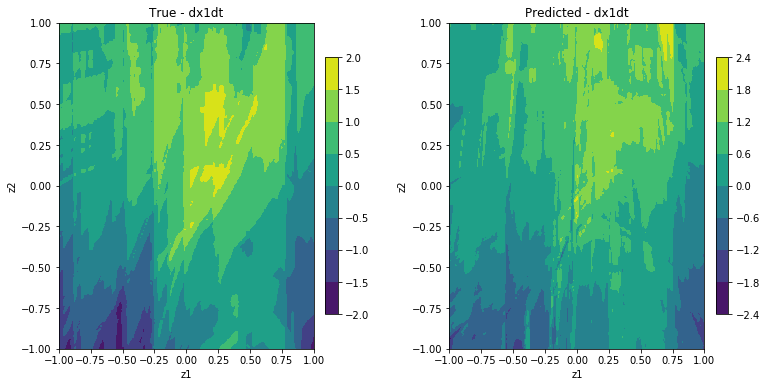

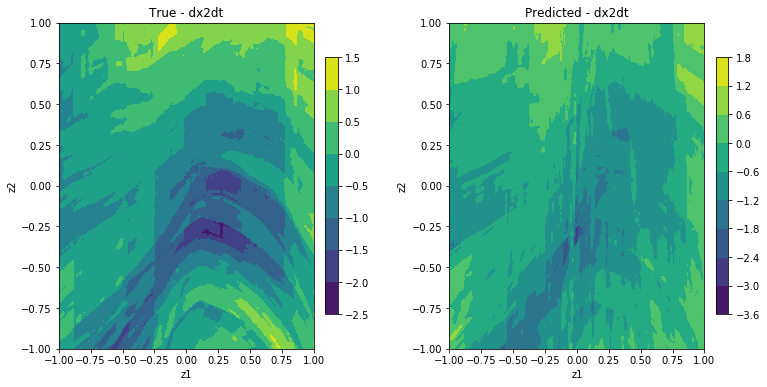

In [40]:
time_step = 4
start_point = time_step*num_points_per_time
end_point = (time_step+1)*num_points_per_time

truth = true_output[start_point:end_point,0].reshape(zx.shape[0],zy.shape[0])
predicted = pred_output[start_point:end_point,0].reshape(zx.shape[0],zy.shape[0])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

cs1 = ax[0].contourf(zxv,zyv,truth)#,levels=levels)
ax[0].set_title('True - dx1dt')
cs2 = ax[1].contourf(zxv,zyv,predicted)#,levels=levels)
ax[1].set_title('Predicted - dx1dt')

for i in range(2):
    ax[i].set_xlabel('z1')
    ax[i].set_ylabel('z2')

fig.colorbar(cs1,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1],fraction=0.046, pad=0.04)
plt.subplots_adjust(wspace = 0.4)
plt.show()


truth = true_output[start_point:end_point,1].reshape(zx.shape[0],zy.shape[0])
predicted = pred_output[start_point:end_point,1].reshape(zx.shape[0],zy.shape[0])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

cs1 = ax[0].contourf(zxv,zyv,truth)#,levels=levels)
ax[0].set_title('True - dx2dt')
cs2 = ax[1].contourf(zxv,zyv,predicted)#,levels=levels)
ax[1].set_title('Predicted - dx2dt')

for i in range(2):
    ax[i].set_xlabel('z1')
    ax[i].set_ylabel('z2')

fig.colorbar(cs1,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1],fraction=0.046, pad=0.04)
plt.subplots_adjust(wspace = 0.4)
plt.show()